# MC-RISE Tutorial

## Introduction

### Table of Contents
* [Set Up Environment](#set-up-environment)
* [The Test Image](#the-test-image)
* [The "Application"](#the-application)
* [Black-Box Classifier](#black-box-classifier)
* [MC-RISE Black-Box Saliency Algorithm](#mc-rise-black-box-saliency-algorithm)
* [Run the "Application"](#run-the-application)

### Miscellaneous
License for test image used may be found in 'COCO-LICENSE.txt'.

#### References
1. Hatakeyama, Y., Sakuma, H., Konishi, Y., & Suenaga, K. (2020). Visualizing color-wise saliency of black-box image classification models. In Proceedings of the Asian Conference on Computer Vision.


To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/docs/examples/MC_RISE.ipynb)

**Note for Colab users**: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/XAITK/xaitk-saliency/blob/master/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

# Set Up Environment


In [1]:
import sys  # noqa: F401

!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q "torch>=1.9.0"
!{sys.executable} -m pip install -q "torchvision>=0.10.0"
!{sys.executable} -m pip install -q transformers

# The Test Image
We will test this application on the following image.
We know that this image contains the [GTSRB dataset](https://benchmark.ini.rub.de/) class: ``Stop``.

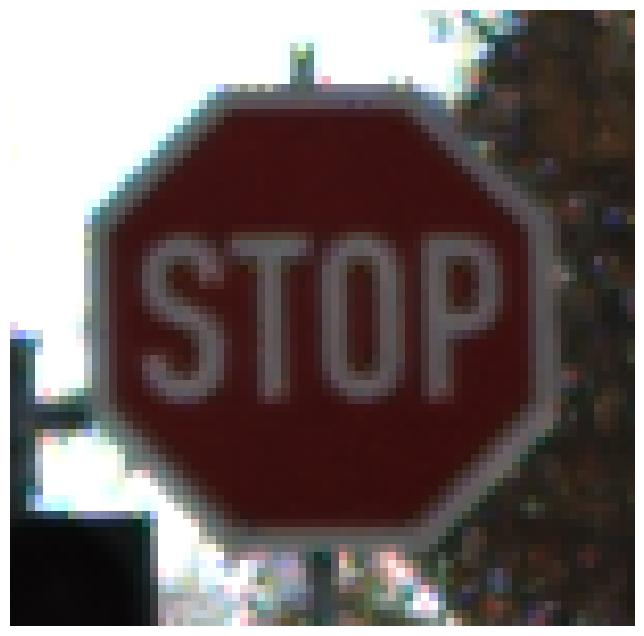

In [1]:
import urllib.request

import matplotlib.pyplot as plt
import PIL.Image
import os

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"

test_image_filename = "data/gtsrb_sample_img.png"
# Create the data directory if it doesn't exist
os.makedirs(os.path.dirname(test_image_filename), exist_ok=True)
urllib.request.urlretrieve(
    "https://data.kitware.com/api/v1/file/6760a0a7290777363f95bff2/download",
    test_image_filename,
)
plt.figure(figsize=(12, 8))
plt.axis("off")
_ = plt.imshow(PIL.Image.open(test_image_filename))

# The "Application"
The xaitk-saliency package provides a relatively high-level API interface for visual saliency map generation.
This interface defines the following input requirements:
  * a reference image
  * a black-box classifier that performs inference over images

As mentioned above, our high-level API accepts black-box classifiers in terms of the `ClassifyImage` interface.

In [2]:
from collections.abc import Sequence

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from smqtk_classifier import ClassifyImage

from xaitk_saliency import GenerateImageClassifierBlackboxSaliency


def app(
    image_filepath: str,
    # Assuming outputs `nClass` length arrays.
    blackbox_classify: ClassifyImage,
    gen_bb_sal: GenerateImageClassifierBlackboxSaliency,
    colors: Sequence[str],
) -> None:
    """Method to run the BlackBox Saliency algorithm"""
    # Load the image
    ref_image = np.asarray(PIL.Image.open(image_filepath))

    sal_maps = gen_bb_sal(ref_image, blackbox_classify)
    print(f"Saliency maps: {sal_maps.shape}")
    visualize_saliency(ref_image, sal_maps, colors)


def visualize_saliency(ref_image: np.ndarray, sal_maps: np.ndarray, colors: Sequence[str]) -> None:
    """Method to visualize positive and negative saliency maps"""
    # Visualize the saliency heat-maps
    plt.figure(figsize=(3, 3))
    plt.imshow(ref_image)
    plt.axis("off")
    plt.title("Test Image")
    plt.show()

    sub_plot_ind = sal_maps.shape[1]
    plt.figure(figsize=(20, 8 * sub_plot_ind))

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046 * (ref_image.shape[0] / ref_image.shape[1]),
        "pad": 0.04,
    }

    n_colors = len(colors)
    for i in range(sal_maps.shape[1]):
        for c_idx, c_name in enumerate(colors):
            class_sal_map = sal_maps[c_idx][i, :, :]
            print(f"Class {i} {c_name} saliency map range: [{class_sal_map.min()}, {class_sal_map.max()}]")

            # Positive half saliency
            plt.subplot(2 * sub_plot_ind, n_colors, (i * 2) * n_colors + c_idx + 1)
            plt.imshow(ref_image, alpha=0.7)
            plt.imshow(np.clip(class_sal_map, 0, 1), cmap="Reds", alpha=0.5)
            plt.clim(0, 1)
            plt.colorbar(**colorbar_kwargs)
            plt.title(f"Class #{i + 1} +ve sal ({c_name})")
            plt.axis("off")

            # Negative half saliency
            plt.subplot(2 * sub_plot_ind, n_colors, (i * 2 + 1) * n_colors + c_idx + 1)
            plt.imshow(ref_image, alpha=0.7)
            plt.imshow(np.clip(class_sal_map, -1, 0), cmap="Blues_r", alpha=0.5)
            plt.clim(-1, 0)
            plt.colorbar(**colorbar_kwargs)
            plt.title(f"Class #{i + 1} -ve sal ({c_name})")
            plt.axis("off")

# Black-Box Classifier
In this example, we will use a basic Huggingface transformers-based, pretrained [CLIPViTModel](https://huggingface.co/tanganke/clip-vit-base-patch32_gtsrb) and use its activation function outpu as classification confidences. Since this model normally outputs 43 classes we will constrain the output to the class (``Stop`` sign) that is relevant for our test image.

In [3]:
from collections.abc import Iterator

import torch
from smqtk_classifier.interfaces.classification_element import CLASSIFICATION_DICT_T
from transformers import ViTForImageClassification, ViTImageProcessor

CUDA_AVAILABLE = torch.cuda.is_available()

# Load model directly
model_name = "cvetanovskaa/vit-base-patch16-224-in21k-gtsrb-tuned"
model = ViTForImageClassification.from_pretrained(model_name)
processor = ViTImageProcessor.from_pretrained(model_name)

device = torch.device("cpu")
if CUDA_AVAILABLE:
    device = torch.device("cuda:0")

model = model.to(device)

# Grabbing the class labels associated with this model.
categories = [labels for k, labels in model.config.id2label.items()]

# For this test, we will use an image with a stop sign in it.
# Let's only consider the saliency of that class' predictions.
sal_class_labels = ["Stop"]
sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]


class CLIPViTModel(ClassifyImage):
    """Blackbox model to output the two focus classes."""

    def get_labels(self) -> list[str]:
        """Returns class label names"""
        return sal_class_labels

    @torch.no_grad()
    def classify_images(self, image_iter: np.ndarray) -> Iterator[CLASSIFICATION_DICT_T]:
        """Classifier implementation"""
        # Input may either be an NDaray, or some arbitrary iterable of NDarray images.
        for img in image_iter:
            inputs = processor(images=img, return_tensors="pt")
            inputs = inputs.to(device)
            outputs = model(**inputs)
            # Converting feature extractor output to probabilities.
            class_conf = torch.nn.functional.tanh(outputs.logits).cpu().detach().numpy().squeeze()
            # Only return the confidences for the focus classes
            yield dict(zip(sal_class_labels, class_conf[sal_class_idxs]))

    def get_config(self) -> dict:
        """Returns config dict"""
        # Required by a parent class.
        return {}


blackbox_classifier = CLIPViTModel()

/data/barry.ravichandran/envs/xaitk-saliency/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MC-RISE Black-Box Saliency Algorithm

We apply the MC-RISE algorithm with 5 colors (red, green, blue, white and black) using the `MCRISEStack` implementation.

In [4]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.mc_rise import MCRISEStack

colors = {
    "red": [255, 0, 0],
    "green": [0, 255, 0],
    "blue": [0, 0, 255],
    "white": [255, 255, 255],
    "black": [0, 0, 0],
}

gen_rise_debiased = MCRISEStack(1000, 8, 0.5, fill_colors=list(colors.values()), seed=0, threads=4)

# Run the "Application"

Saliency maps: (5, 1, 75, 76)


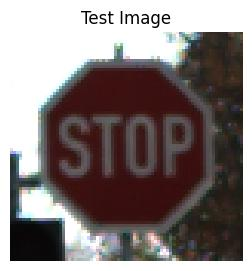

Class 0 red saliency map range: [-0.9577963855670709, 1.0]
Class 0 green saliency map range: [-1.0, 0.7505524578654462]
Class 0 blue saliency map range: [-1.0, 0.9028794601007086]
Class 0 white saliency map range: [-1.0, 0.43338210200573707]
Class 0 black saliency map range: [-0.7162993764197221, 1.0]


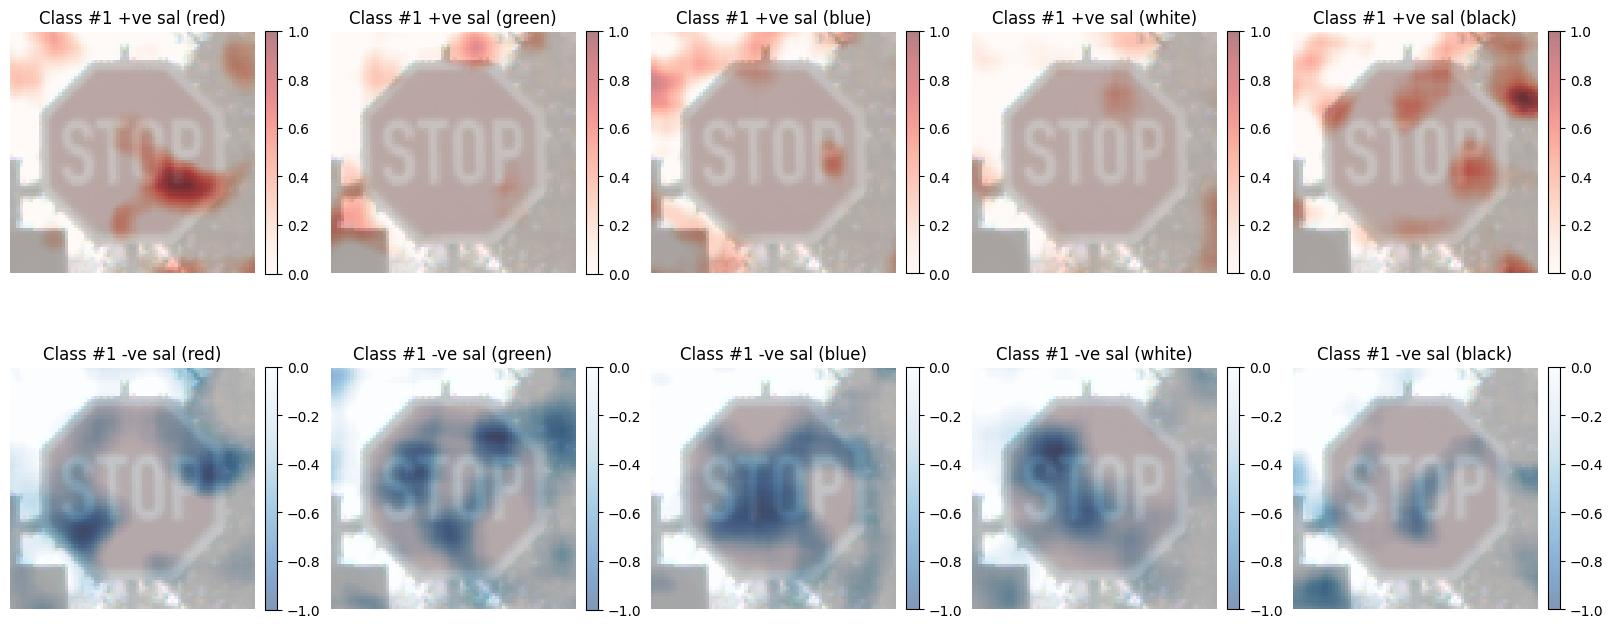

In [5]:
app(
    test_image_filename,
    blackbox_classifier,
    gen_rise_debiased,
    colors.keys(),
)